## Dataset Preparation


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [111]:
p=Path(r"./classification/train")

In [112]:
labels_dict={"not-a-gun":0,"gun":1}
labels=[]
image_data=[]
for folder_name in p.glob("*"):
    label=str(folder_name).split("\\")[-1]
    i=0
    for image_path in folder_name.glob("*.jpg"):
        i+=1
        if i>100:
            break
    
        img=image.load_img(image_path,target_size=(32,32))
        
        img_array=image.img_to_array(img)
        
        image_data.append(img_array)
        
        labels.append(labels_dict[label])

In [113]:
print(len(labels))
print(len(image_data))


10000
10000


In [114]:
print(type(image_data),type(labels))

<class 'list'> <class 'list'>


##### conversion into numpy array


In [115]:
image_data=np.array(image_data,dtype="float32")/255.0
labels=np.array(labels)

In [116]:
print(image_data.shape,labels.shape)

(10000, 32, 32, 3) (10000,)


#### random shuffling


In [117]:
import random
combine=list(zip(image_data,labels))
random.shuffle(combine)
image_data[:],labels[:]=zip(*combine)

#### visualisation


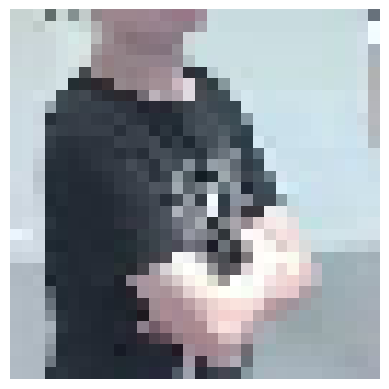

In [118]:
def drawimage(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


drawimage(image_data[0])

## SVM Classifier


In [119]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        
        W = np.zeros((1,no_of_features))
        bias = 0
        
        
        losses = []
        
        for i in range(maxItr):
            
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            
            for batch_start in range(0,no_of_samples,batch_size):
                
                gradw = 0
                gradb = 0
                
                
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

## One Versus One classifcation


In [120]:
# each sample of image in image data have 16875 feature
m = image_data.shape[0]
image_data= image_data.reshape(m,-1)
print(image_data.shape)
print(labels.shape)


(10000, 3072)
(10000,)


In [121]:
total_class = len(np.unique(labels))
print(total_class)

2


#### prepare class wise data


In [122]:
def classwisedata(x,y):
    data= {}
    for i in range(total_class):
        data[i]=[]
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

In [123]:
data= classwisedata(image_data,labels)

In [124]:
data.keys()

dict_keys([0, 1])

In [125]:
print(type(data[0]))
print(type(data[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [126]:
print(data[0].shape)
print(data[1].shape)

(5000, 3072)
(5000, 3072)


In [127]:
def getDataPairForSVM(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

## Training NC2 SVM's Part!


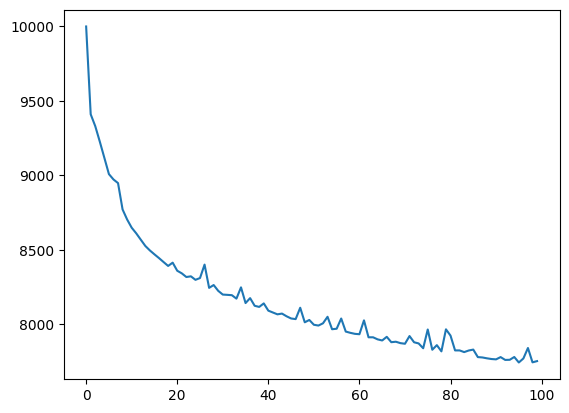

In [128]:
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=100)
#print(loss)
plt.plot(loss)


In [ ]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(total_class):
        svm_classifiers[i] = {}
        for j in range(i+1,total_class):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=500)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    
    return svm_classifiers

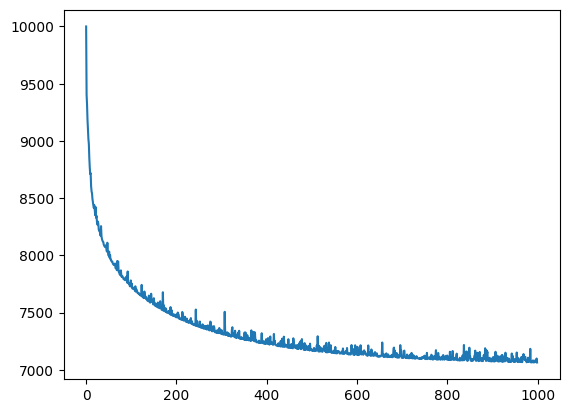

In [132]:
svm_classifier = trainSVMs(image_data,labels)

In [133]:
#Parameters for Cats and dogs
cats_dogs = svm_classifier
cats_humans = svm_classifier[1]
print(cats_dogs)
print(cats_humans)

{0: {1: (array([[ 0.05792267,  0.00785882,  0.00324932, ..., -0.01941327,
        -0.04650472, -0.04652973]]), 1.5425200000000163)}, 1: {}}
{}


In [134]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [135]:
def predict(x):
    
    count = np.zeros((total_class,))
    
    for i in range(total_class):
        for j in range(i+1,total_class):
            w,b = svm_classifier[i][j]
            
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [136]:
print(predict(image_data[1000]))
print(labels[100])

0
1


In [137]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [138]:
accuracy(image_data,labels)

0.6827

## SVM using SK-learn


In [139]:
from sklearn import svm

In [140]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)

In [141]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.7286

In [ ]:
svm_classifier.predict(image_data)

array([0, 0, 1, 0, 1, 0, 0, 1, 3, 1, 2, 0, 3, 0, 0, 0, 0, 2, 2, 1, 2, 0,
       0, 2, 3, 0, 1, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 1, 1, 0, 3, 0, 3, 2,
       0, 0, 3, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 3, 0, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3,
       3, 1, 0, 0, 0, 3, 2, 1, 3, 0, 0, 2, 0, 0, 2, 1, 0, 0, 3, 2, 0, 0,
       2, 2, 0, 3, 0, 2, 0, 2, 1, 0, 1, 2, 0, 3, 3, 0, 1, 0, 0, 3, 0, 0,
       0, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 3, 3, 0, 2, 0, 2, 2, 0, 0, 0,
       1, 2, 1, 1, 1, 3, 0, 0, 1, 1, 2, 0, 2, 2, 0, 1, 3, 3, 1, 3, 0, 2,
       1, 3, 0, 0, 1, 0, 1, 2, 2, 1, 0, 2, 3, 3, 2, 3, 0, 2, 0, 0, 1, 2,
       0, 0, 2, 0, 2, 3, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 0, 1, 2, 1, 1,
       3, 1, 1, 1, 3, 2, 0, 1, 2, 1, 3, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 1, 0, 3, 1, 3, 2, 0, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 1,
       1, 2, 2, 3, 0, 3, 1, 2, 1, 1, 2, 2, 2, 3, 2, 1, 2, 1, 1, 3, 2, 3,
       3, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 3, 1, 3, 2,